In [34]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
from tensorflow import saved_model

In [2]:
def feature_extraction(video_path):
    width = 80
    height = 60
    sequence_length = 10
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_interval = max(int(frame_count / sequence_length), 1)

    for counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        ret, frame = video_reader.read()
        if not ret:
            break
        frame = cv2.resize(frame, (height, width))
        frame = frame / 255
        frames_list.append(frame)
    video_reader.release()
    return frames_list

In [3]:
def load_video(datasets):
    label_index = 0
    labels = []
    images = []

    for folder in datasets:
        #for file in tqdm(os.listdir(folder)[:20]):  # Only take 20 videos per category
        for file in tqdm(os.listdir(folder)):
            video_path = os.path.join(folder, file)
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index += 1

    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

In [4]:
label_data = pd.read_csv("/Users/LeoSu/Desktop/research/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns = ['index', 'labels']
label_data = label_data.drop(['index'], axis=1)

path = []
for label in label_data.labels.values:
    path.append('/Users/LeoSu/Desktop/research/UCF101/UCF-101/'+label+"/")

images, labels = load_video(path[:30])

100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 27.89it/s]


In [5]:
images[0].shape

(10, 80, 60, 3)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.06, random_state=10)

### Model 1

In [35]:
# 1 Simple CNN + LSTM model
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='LeakyReLU'), input_shape=(None, x_train.shape[2], x_train.shape[3], 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='LeakyReLU')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='LeakyReLU')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(Flatten()))
#model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(30, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 78, 58, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 39, 29, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 39, 29, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 37, 27, 64)  18496    
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 18, 13, 64)  

In [36]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics='accuracy')

es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history = model.fit(x_train, to_categorical(y_train), batch_size=32, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Epoch 1/50


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/8f53d7fd-3013-11ee-8ab0-7a03568b17ac/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<320x39x29x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/8f53d7fd-3013-11ee-8ab0-7a03568b17ac/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<320x18x13x64xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/8f53d7fd-3013-11ee-8ab0-7a03568b17ac/Library/Caches/com.apple.xbs/Sources/MetalPerfo

118/119 [============================>.] - ETA: 0s - loss: 2.9273 - accuracy: 0.1803

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/8f53d7fd-3013-11ee-8ab0-7a03568b17ac/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<150x39x29x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/8f53d7fd-3013-11ee-8ab0-7a03568b17ac/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<150x18x13x64xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/8f53d7fd-3013-11ee-8ab0-7a03568b17ac/Library/Caches/com.apple.xbs/Sources/MetalPerfo

119/119 [==============================] - 19s 99ms/step - loss: 2.9259 - accuracy: 0.1807 - val_loss: 2.2515 - val_accuracy: 0.3306
Epoch 2/50
119/119 [==============================] - 7s 61ms/step - loss: 2.0809 - accuracy: 0.4023 - val_loss: 1.8160 - val_accuracy: 0.4793
Epoch 3/50
119/119 [==============================] - 7s 62ms/step - loss: 1.6399 - accuracy: 0.5418 - val_loss: 1.5264 - val_accuracy: 0.5537
Epoch 4/50
119/119 [==============================] - 7s 62ms/step - loss: 1.3127 - accuracy: 0.6486 - val_loss: 1.2901 - val_accuracy: 0.6322
Epoch 5/50
119/119 [==============================] - 7s 62ms/step - loss: 1.0690 - accuracy: 0.7265 - val_loss: 0.9904 - val_accuracy: 0.7645
Epoch 6/50
119/119 [==============================] - 8s 64ms/step - loss: 0.8710 - accuracy: 0.7866 - val_loss: 0.8788 - val_accuracy: 0.7893
Epoch 7/50
119/119 [==============================] - 7s 63ms/step - loss: 0.6972 - accuracy: 0.8367 - val_loss: 0.7357 - val_accuracy: 0.8264
Epoch 8/5

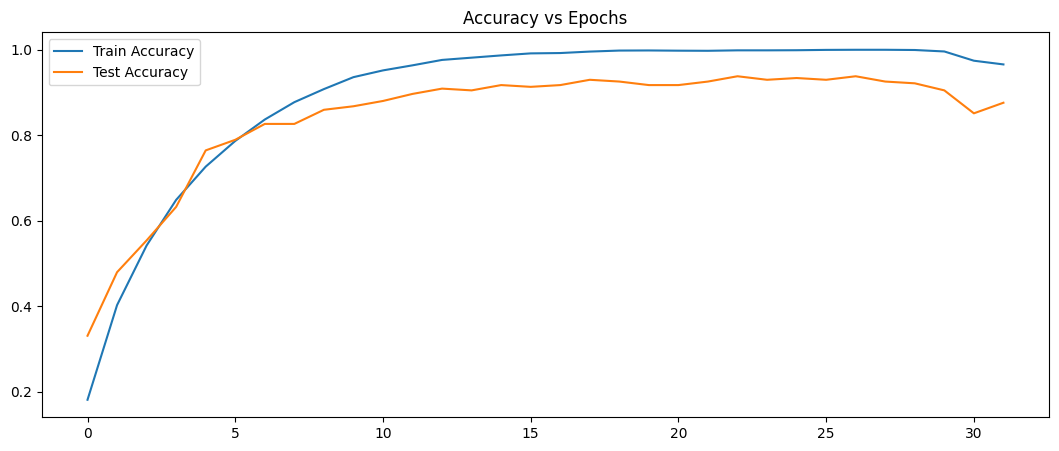

In [37]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [38]:
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))
#Test Accuracy
accuracy_score(y_test, predicted_classes)

8/8 [==============================] - 2s 87ms/step


0.9380165289256198

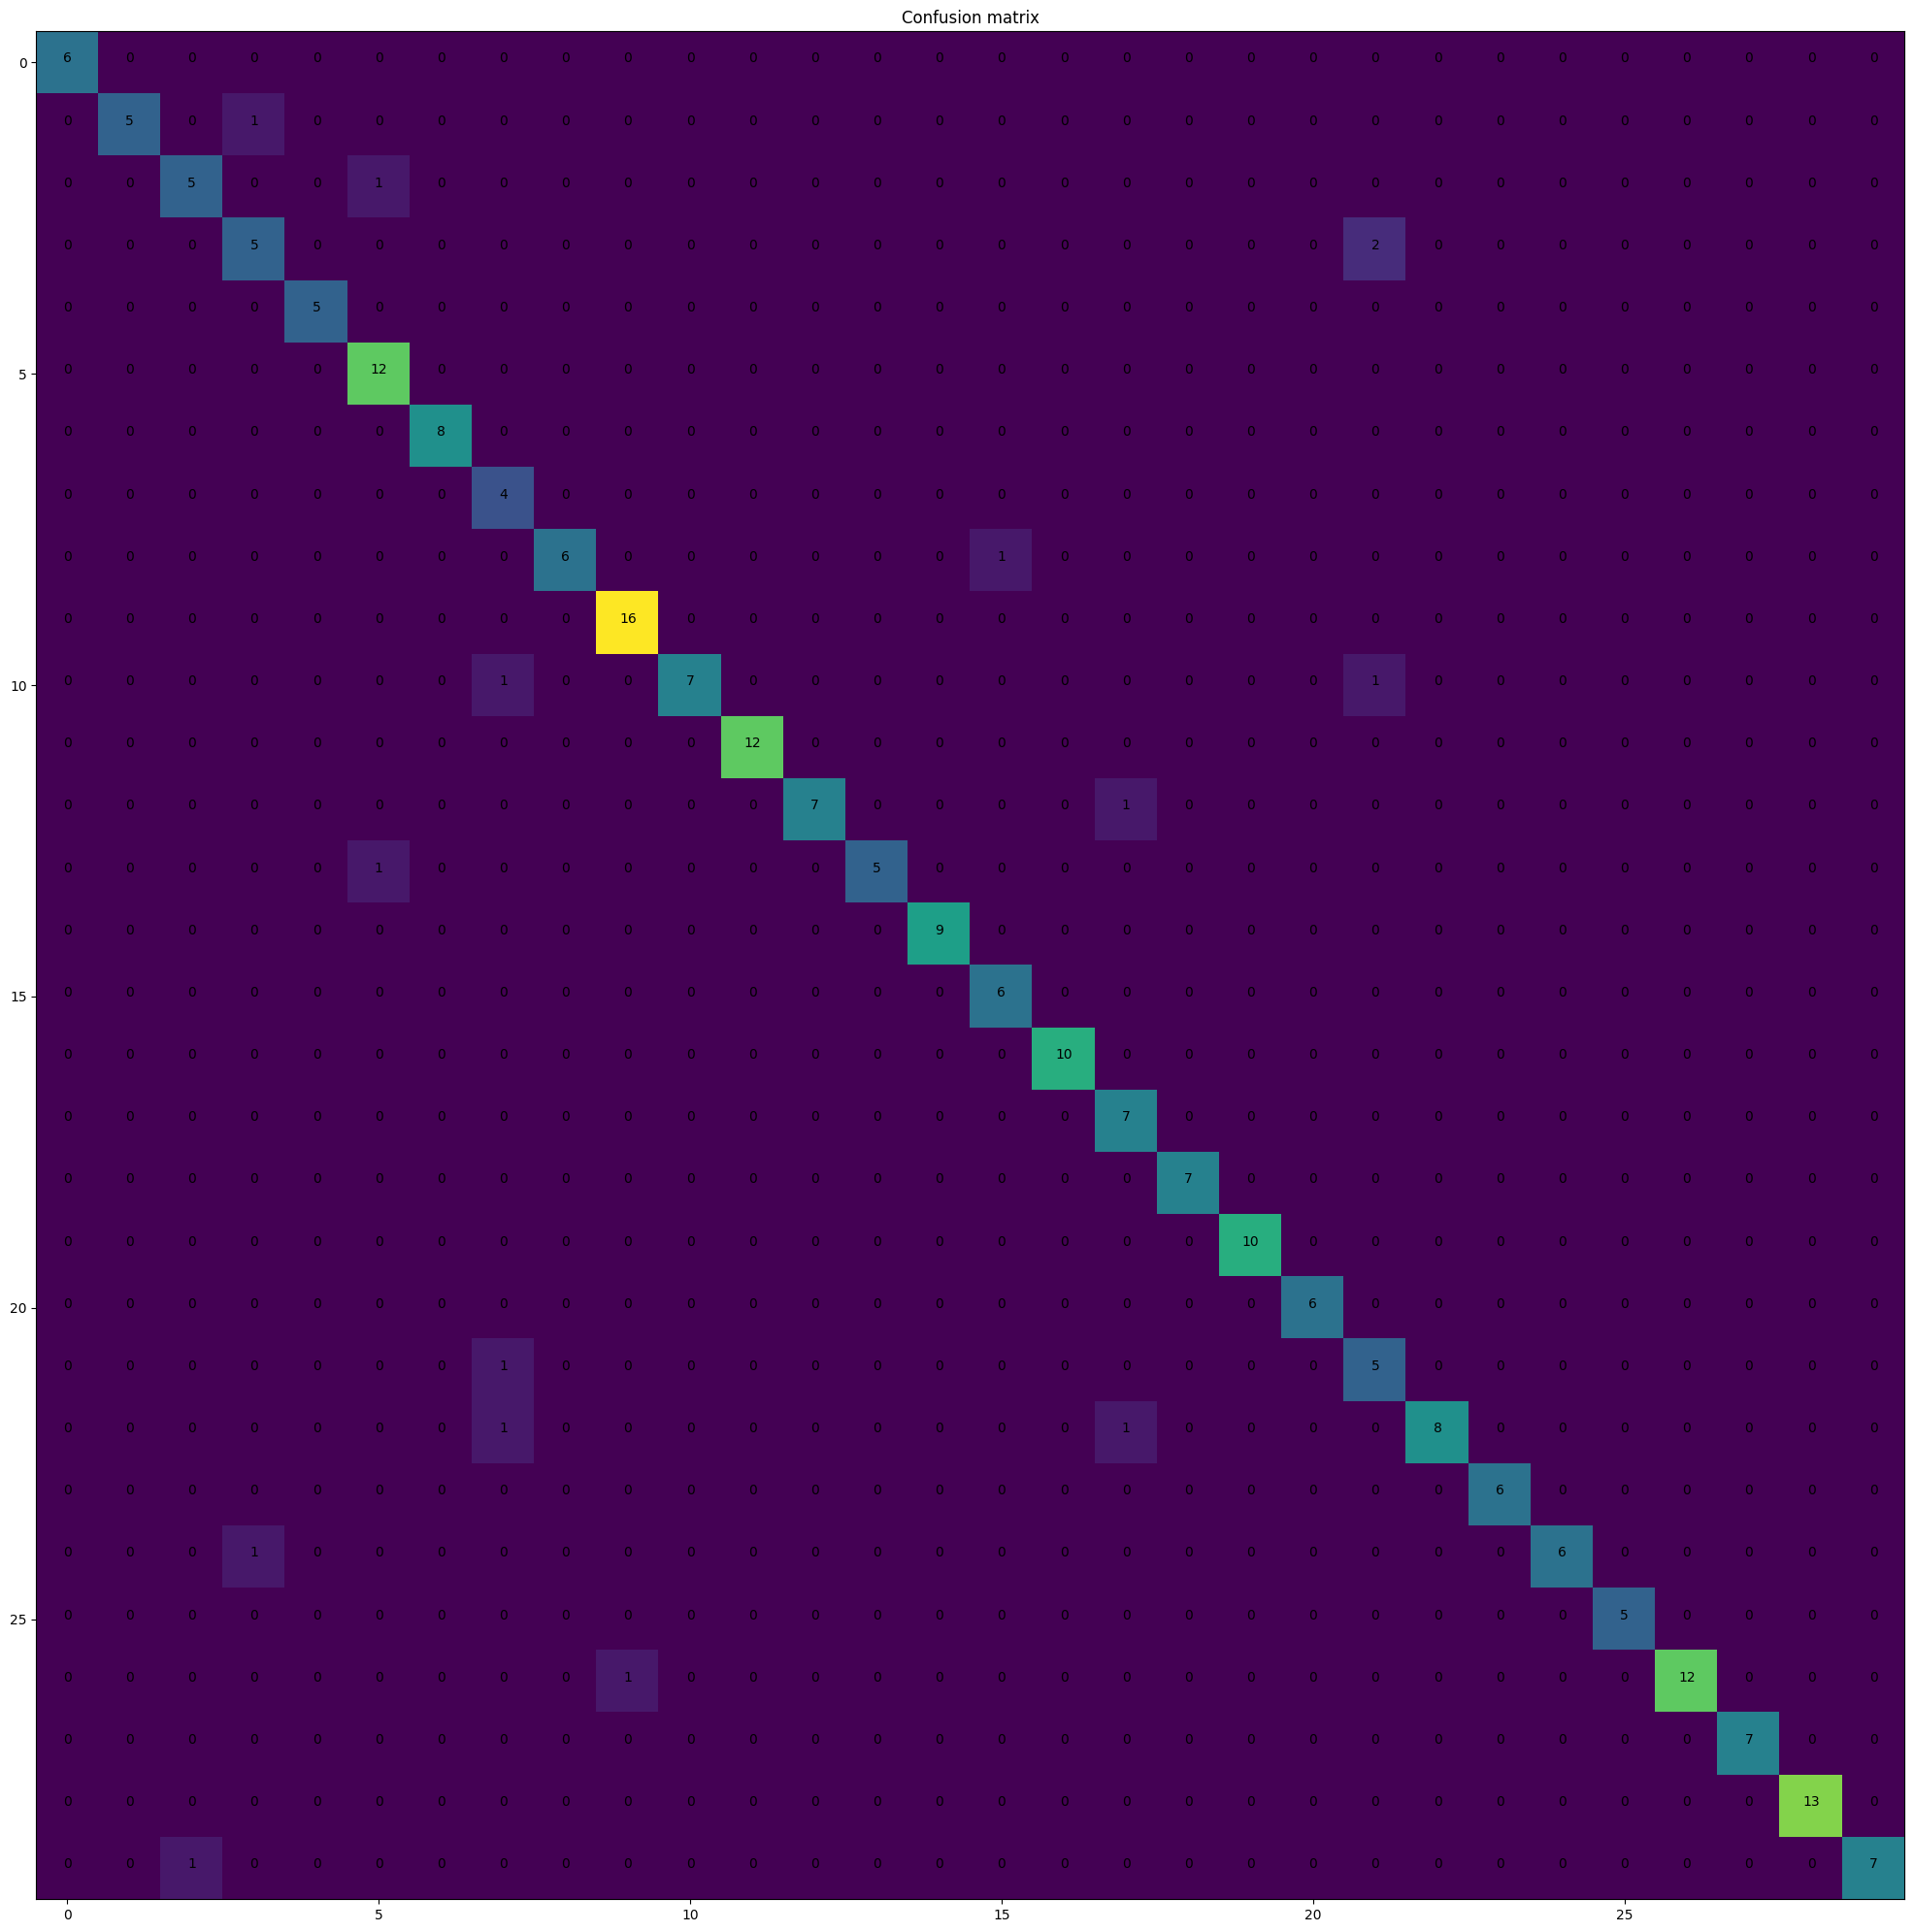

In [39]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

### Model 2

In [30]:
# Now, we build a ConvLSTM2D model
model2 = Sequential()
model2.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='LeakyReLU', input_shape=(None, x_train.shape[2], x_train.shape[3], 3), data_format='channels_last', return_sequences=True))
model2.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#model2.add(BatchNormalization())
model2.add(GlobalAveragePooling3D())

model2.add(Dense(4096,activation="relu"))
model2.add(Dense(30, activation='softmax'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 78, 58, 32)  40448     
                                                                 
 time_distributed_50 (TimeDi  (None, None, 39, 29, 32)  0        
 stributed)                                                      
                                                                 
 global_average_pooling3d (G  (None, 32)               0         
 lobalAveragePooling3D)                                          
                                                                 
 dense_6 (Dense)             (None, 4096)              135168    
                                                                 
 dense_7 (Dense)             (None, 30)                122910    
                                                                 
Total params: 298,526
Trainable params: 298,526
Non-tr

In [31]:
model2.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics='accuracy')

es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history2 = model2.fit(x_train, to_categorical(y_train), batch_size=32, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Epoch 1/50


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x78x58x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x78x58x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerform

119/119 [==============================] - ETA: 0s - loss: 3.2675 - accuracy: 0.0657

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x78x58x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x78x58x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerform

119/119 [==============================] - 164s 1s/step - loss: 3.2675 - accuracy: 0.0657 - val_loss: 3.0508 - val_accuracy: 0.1033
Epoch 2/50
119/119 [==============================] - 158s 1s/step - loss: 2.9959 - accuracy: 0.1324 - val_loss: 2.7980 - val_accuracy: 0.1860
Epoch 3/50
119/119 [==============================] - 163s 1s/step - loss: 2.7944 - accuracy: 0.1749 - val_loss: 2.6996 - val_accuracy: 0.2231
Epoch 4/50
119/119 [==============================] - 162s 1s/step - loss: 2.6090 - accuracy: 0.2189 - val_loss: 2.5261 - val_accuracy: 0.2479
Epoch 5/50
119/119 [==============================] - 162s 1s/step - loss: 2.4726 - accuracy: 0.2538 - val_loss: 2.3235 - val_accuracy: 0.2686
Epoch 6/50
119/119 [==============================] - 160s 1s/step - loss: 2.3448 - accuracy: 0.2939 - val_loss: 2.1593 - val_accuracy: 0.3264
Epoch 7/50
119/119 [==============================] - 163s 1s/step - loss: 2.2030 - accuracy: 0.3295 - val_loss: 2.0547 - val_accuracy: 0.3430
Epoch 8/50

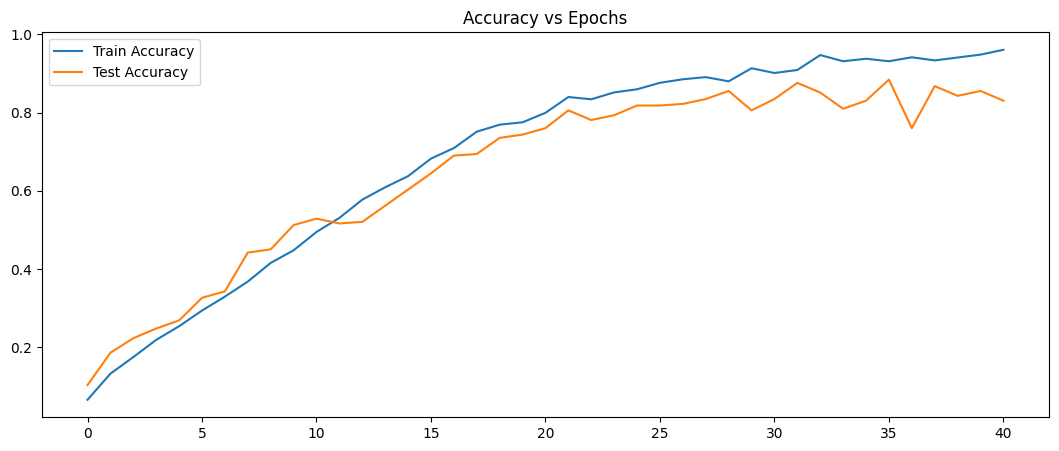

In [32]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [33]:
y_pred = model2.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))
#Test Accuracy
accuracy_score(y_test, predicted_classes)

8/8 [==============================] - 1s 119ms/step


0.8842975206611571

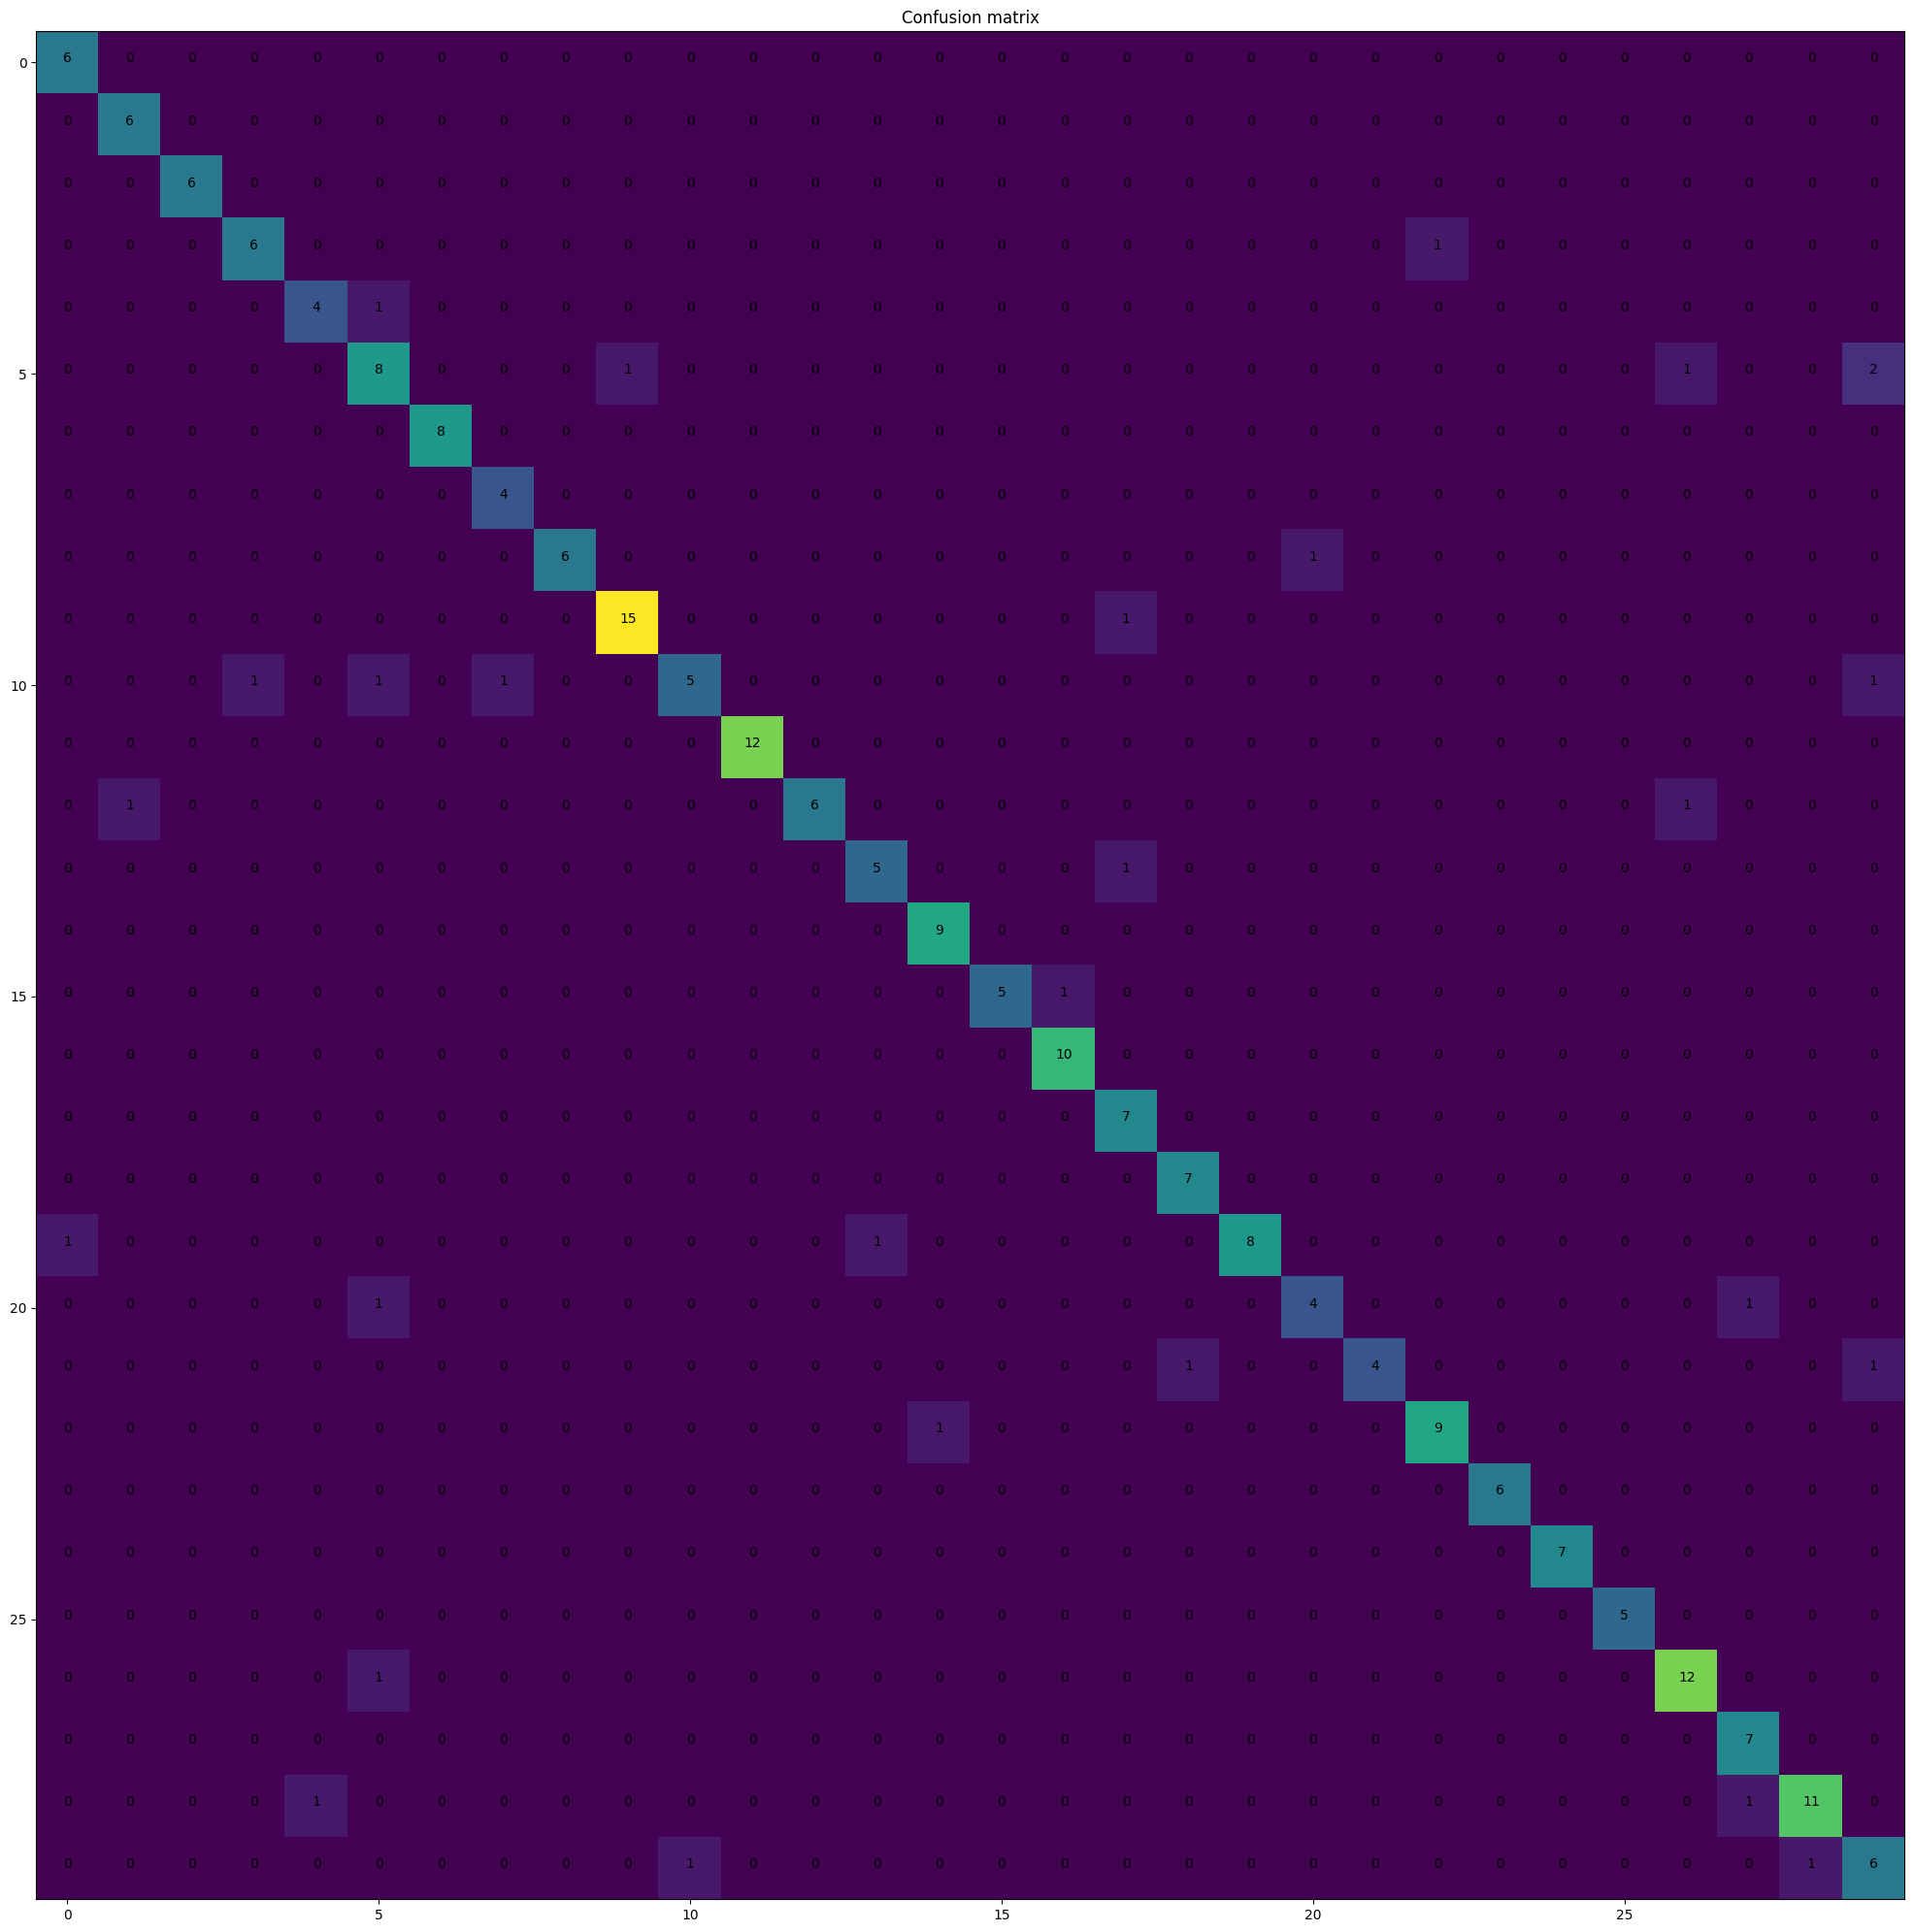

In [34]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

### Model 3

In [35]:
# 2 ConvLSTM2D model Final Version
model3 = Sequential()

model3.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2, input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model3.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model3.add(TimeDistributed(Dropout(0.2)))

model3.add(ConvLSTM2D(filters = 32, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model3.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model3.add(TimeDistributed(Dropout(0.2)))

model3.add(ConvLSTM2D(filters = 64, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model3.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model3.add(TimeDistributed(Dropout(0.2)))

model3.add(Flatten())
          
model3.add(Dense(30, activation='softmax'))
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 10, 78, 58, 16)    11008     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 39, 29, 16)   0         
 3D)                                                             
                                                                 
 time_distributed_51 (TimeDi  (None, 10, 39, 29, 16)   0         
 stributed)                                                      
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 10, 37, 27, 32)    55424     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 19, 14, 32)   0         
 3D)                                                             
                                                      

In [36]:
model3.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics='accuracy')

es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history3 = model3.fit(x_train, to_categorical(y_train), batch_size=32, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Epoch 1/50


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerform

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<320x19x14x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x37x27x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerfor

118/119 [============================>.] - ETA: 2s - loss: 2.7659 - accuracy: 0.2206

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerform

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<150x19x14x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x37x27x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerfor

119/119 [==============================] - ETA: 0s - loss: 2.7645 - accuracy: 0.2213

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerform

119/119 [==============================] - 302s 3s/step - loss: 2.7645 - accuracy: 0.2213 - val_loss: 2.0832 - val_accuracy: 0.3554
Epoch 2/50
119/119 [==============================] - 312s 3s/step - loss: 1.7704 - accuracy: 0.4930 - val_loss: 1.3095 - val_accuracy: 0.6116
Epoch 3/50
119/119 [==============================] - 319s 3s/step - loss: 0.9834 - accuracy: 0.7159 - val_loss: 1.0075 - val_accuracy: 0.6983
Epoch 4/50
119/119 [==============================] - 321s 3s/step - loss: 0.5574 - accuracy: 0.8362 - val_loss: 0.8799 - val_accuracy: 0.7149
Epoch 5/50
119/119 [==============================] - 321s 3s/step - loss: 0.3528 - accuracy: 0.8916 - val_loss: 0.6816 - val_accuracy: 0.8223
Epoch 6/50
119/119 [==============================] - 321s 3s/step - loss: 0.2156 - accuracy: 0.9325 - val_loss: 0.5946 - val_accuracy: 0.8512
Epoch 7/50
119/119 [==============================] - 321s 3s/step - loss: 0.1416 - accuracy: 0.9546 - val_loss: 0.5892 - val_accuracy: 0.8347
Epoch 8/50

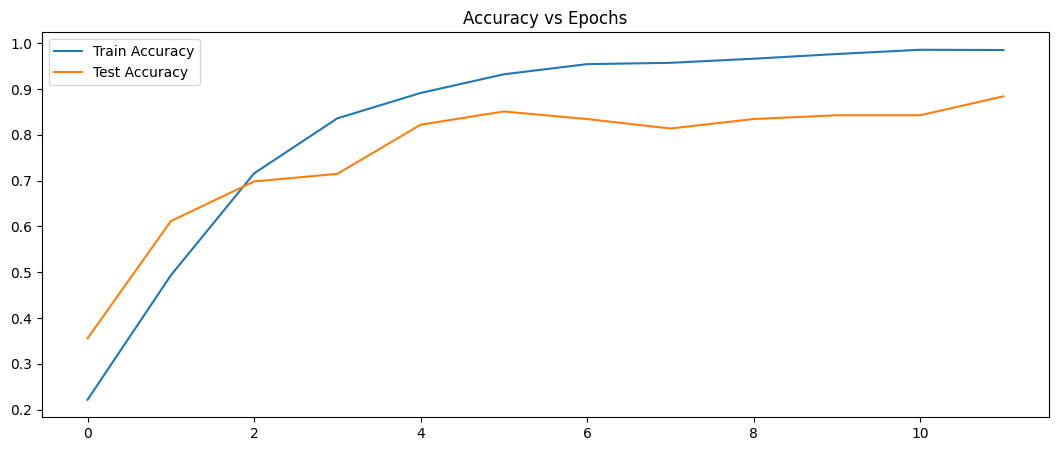

In [37]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [38]:
y_pred = model3.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))
#Test Accuracy
accuracy_score(y_test, predicted_classes)

8/8 [==============================] - 3s 287ms/step


0.8347107438016529

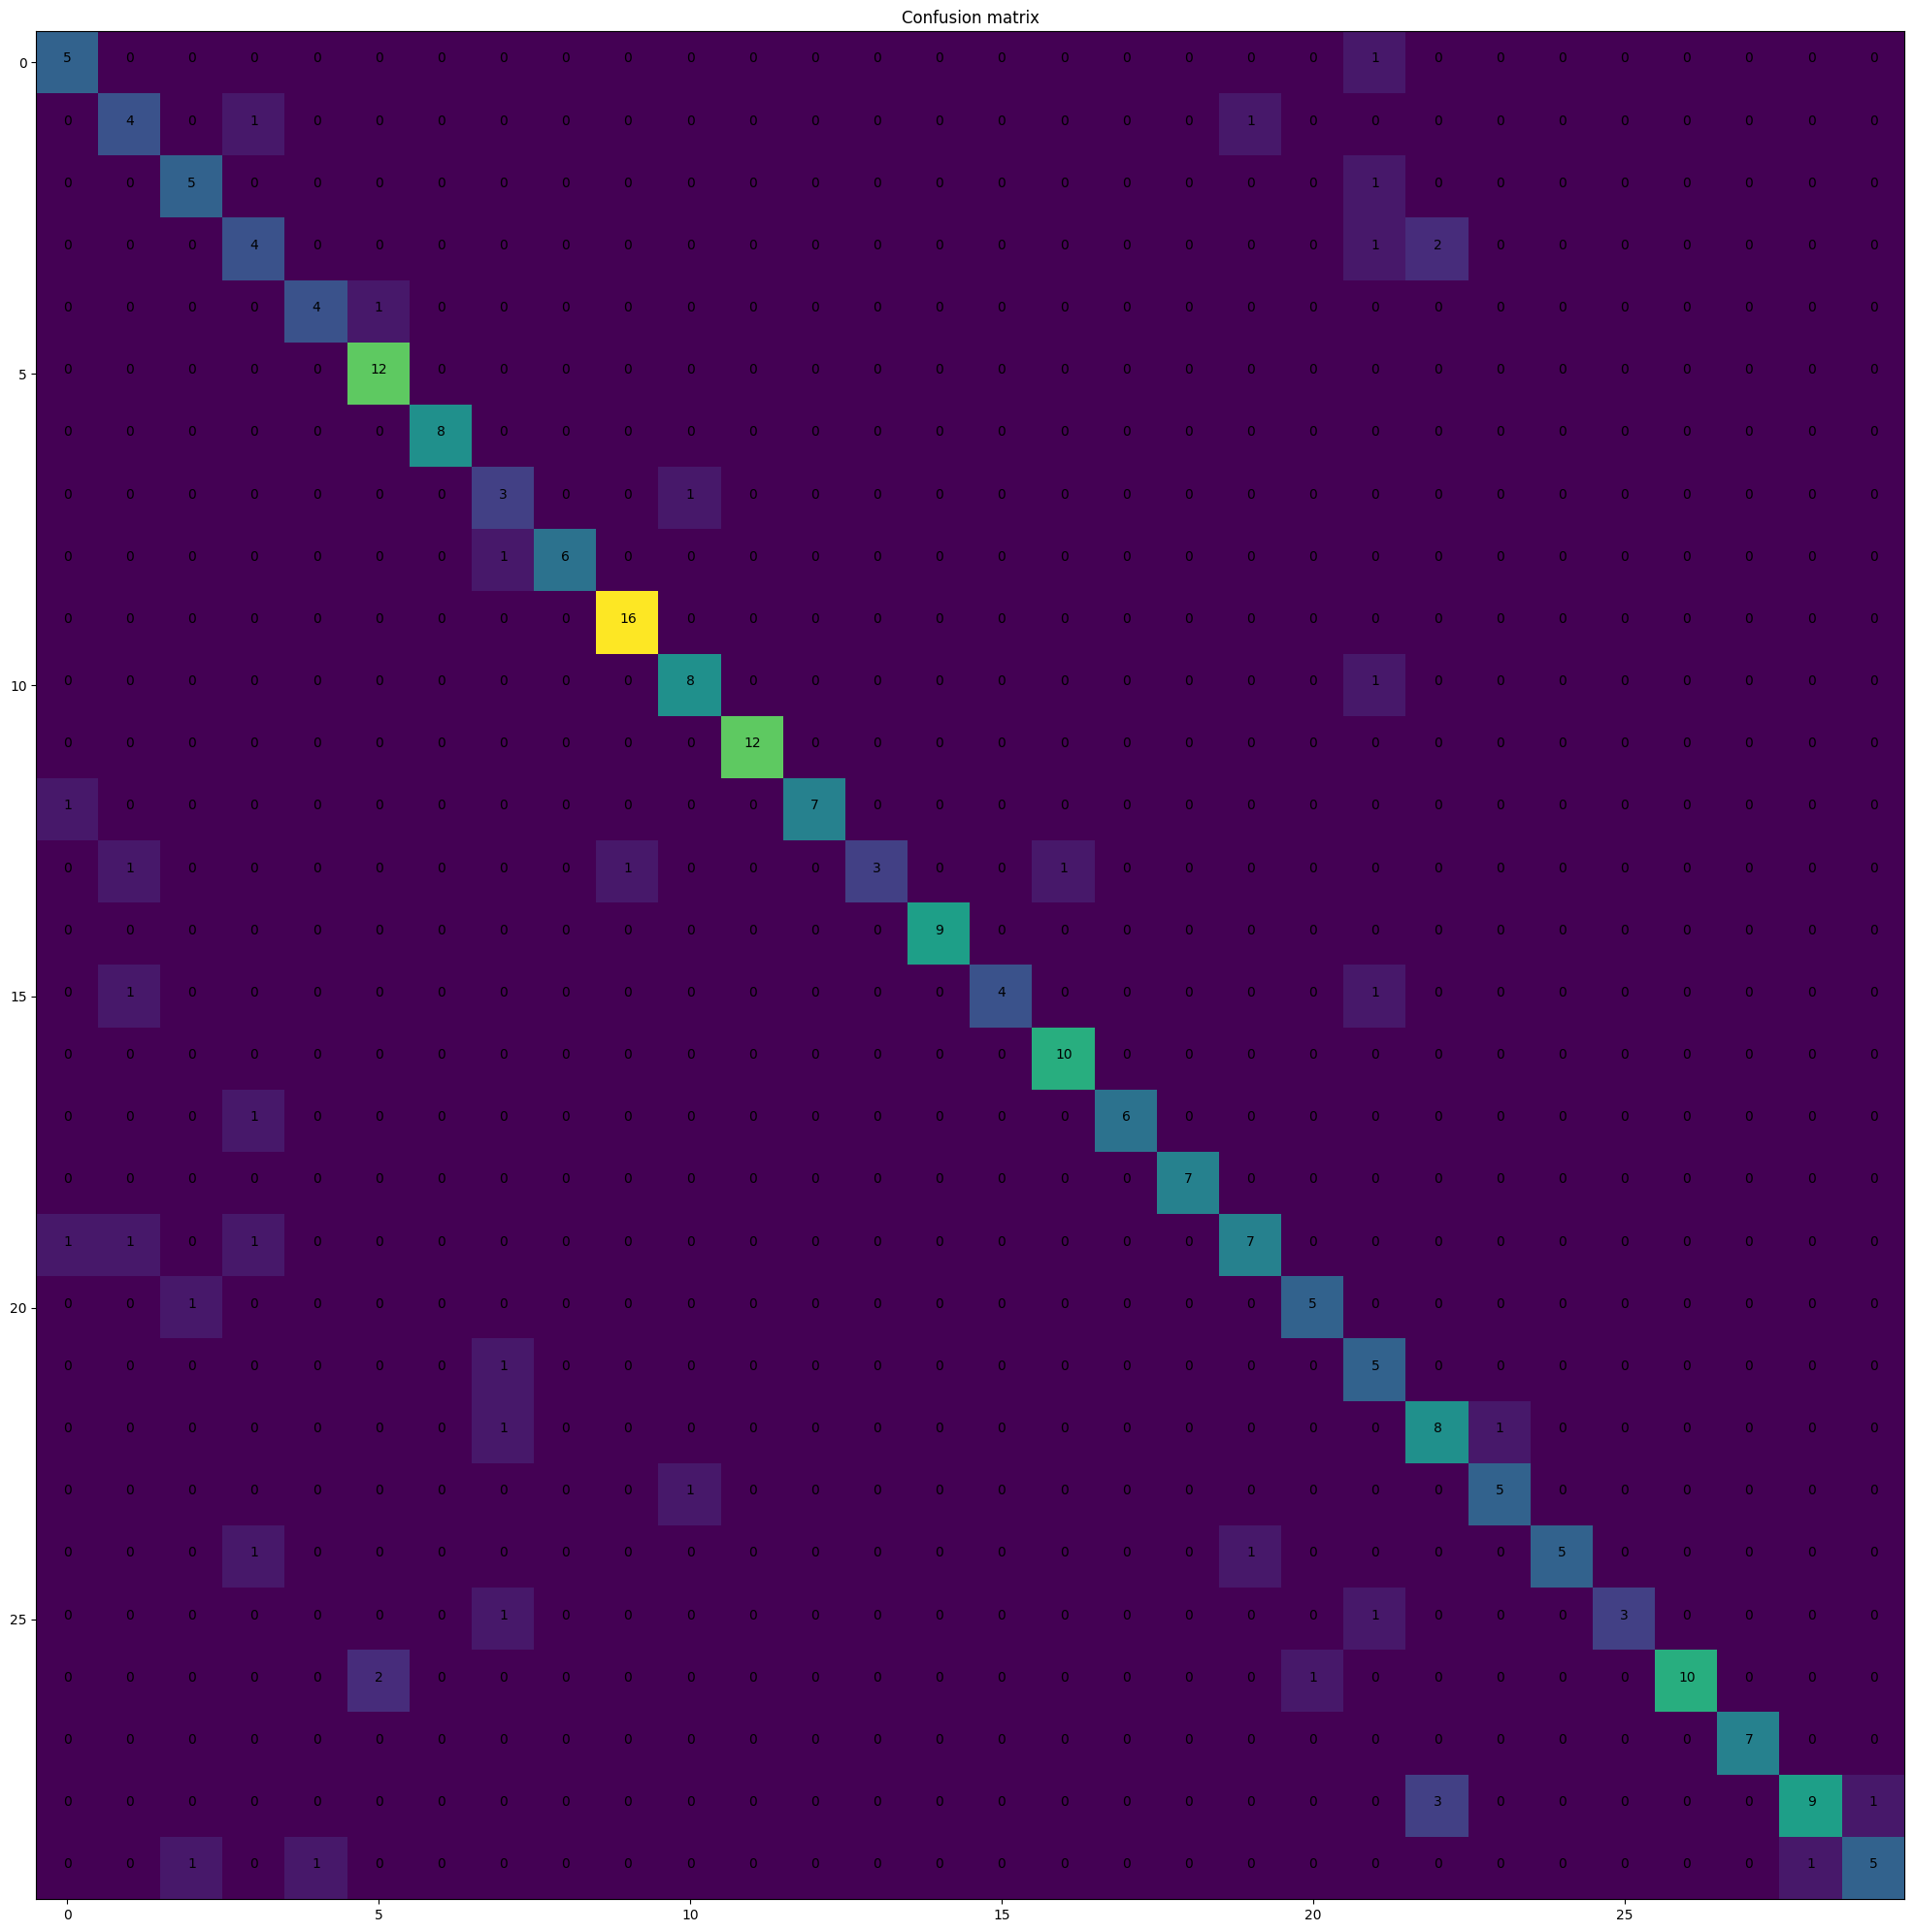

In [39]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

### Model 4

In [44]:
model4 = Sequential()

model4.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2, input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model4.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model4.add(TimeDistributed(Dropout(0.2)))

model4.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model4.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model4.add(TimeDistributed(Dropout(0.2)))

model4.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model4.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model4.add(TimeDistributed(Dropout(0.2)))

model4.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model4.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model4.add(TimeDistributed(Dropout(0.2)))

model4.add(Flatten())
          
model4.add(Dense(30, activation='softmax'))
model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_23 (ConvLSTM2D)  (None, 10, 78, 58, 16)   11008     
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 10, 39, 29, 16)   0         
 g3D)                                                            
                                                                 
 time_distributed_70 (TimeDi  (None, 10, 39, 29, 16)   0         
 stributed)                                                      
                                                                 
 conv_lstm2d_24 (ConvLSTM2D)  (None, 10, 37, 27, 16)   18496     
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 10, 19, 14, 16)   0         
 g3D)                                                            
                                                     

In [45]:
model4.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics='accuracy')

es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history4 = model4.fit(x_train, to_categorical(y_train), batch_size=32, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Epoch 1/50


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerform

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x7x4x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<32x7x4x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformance

118/119 [============================>.] - ETA: 2s - loss: 3.2541 - accuracy: 0.0837

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerform

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x7x4x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x7x4x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformance

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<15x78x58x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/ec9ec6a1-21b0-11ee-8c40-aead88ae2785/Library/Caches/com.apple.xbs/Sources/MetalPerform

119/119 [==============================] - 298s 2s/step - loss: 3.2538 - accuracy: 0.0839 - val_loss: 3.0119 - val_accuracy: 0.1488
Epoch 2/50
119/119 [==============================] - 286s 2s/step - loss: 2.7084 - accuracy: 0.2192 - val_loss: 2.3720 - val_accuracy: 0.3430
Epoch 3/50
119/119 [==============================] - 286s 2s/step - loss: 2.2753 - accuracy: 0.3371 - val_loss: 2.0608 - val_accuracy: 0.3926
Epoch 4/50
119/119 [==============================] - 295s 2s/step - loss: 1.9649 - accuracy: 0.4123 - val_loss: 1.8832 - val_accuracy: 0.4587
Epoch 5/50
119/119 [==============================] - 305s 3s/step - loss: 1.7090 - accuracy: 0.4785 - val_loss: 1.7700 - val_accuracy: 0.4587
Epoch 6/50
119/119 [==============================] - 307s 3s/step - loss: 1.5323 - accuracy: 0.5297 - val_loss: 1.5197 - val_accuracy: 0.5289
Epoch 7/50
119/119 [==============================] - 312s 3s/step - loss: 1.3310 - accuracy: 0.5922 - val_loss: 1.4097 - val_accuracy: 0.5620
Epoch 8/50

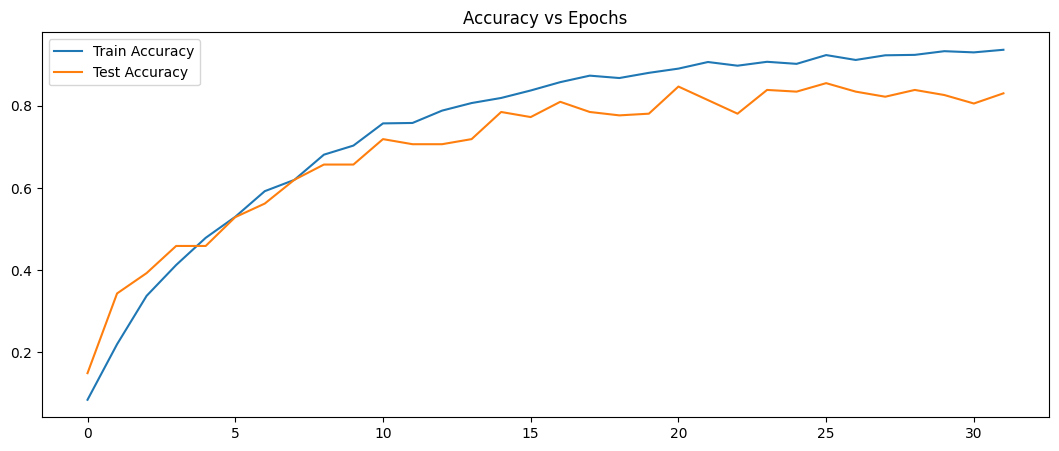

In [46]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [47]:
y_pred = model4.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))
#Test Accuracy
accuracy_score(y_test, predicted_classes)

8/8 [==============================] - 4s 413ms/step


0.8347107438016529

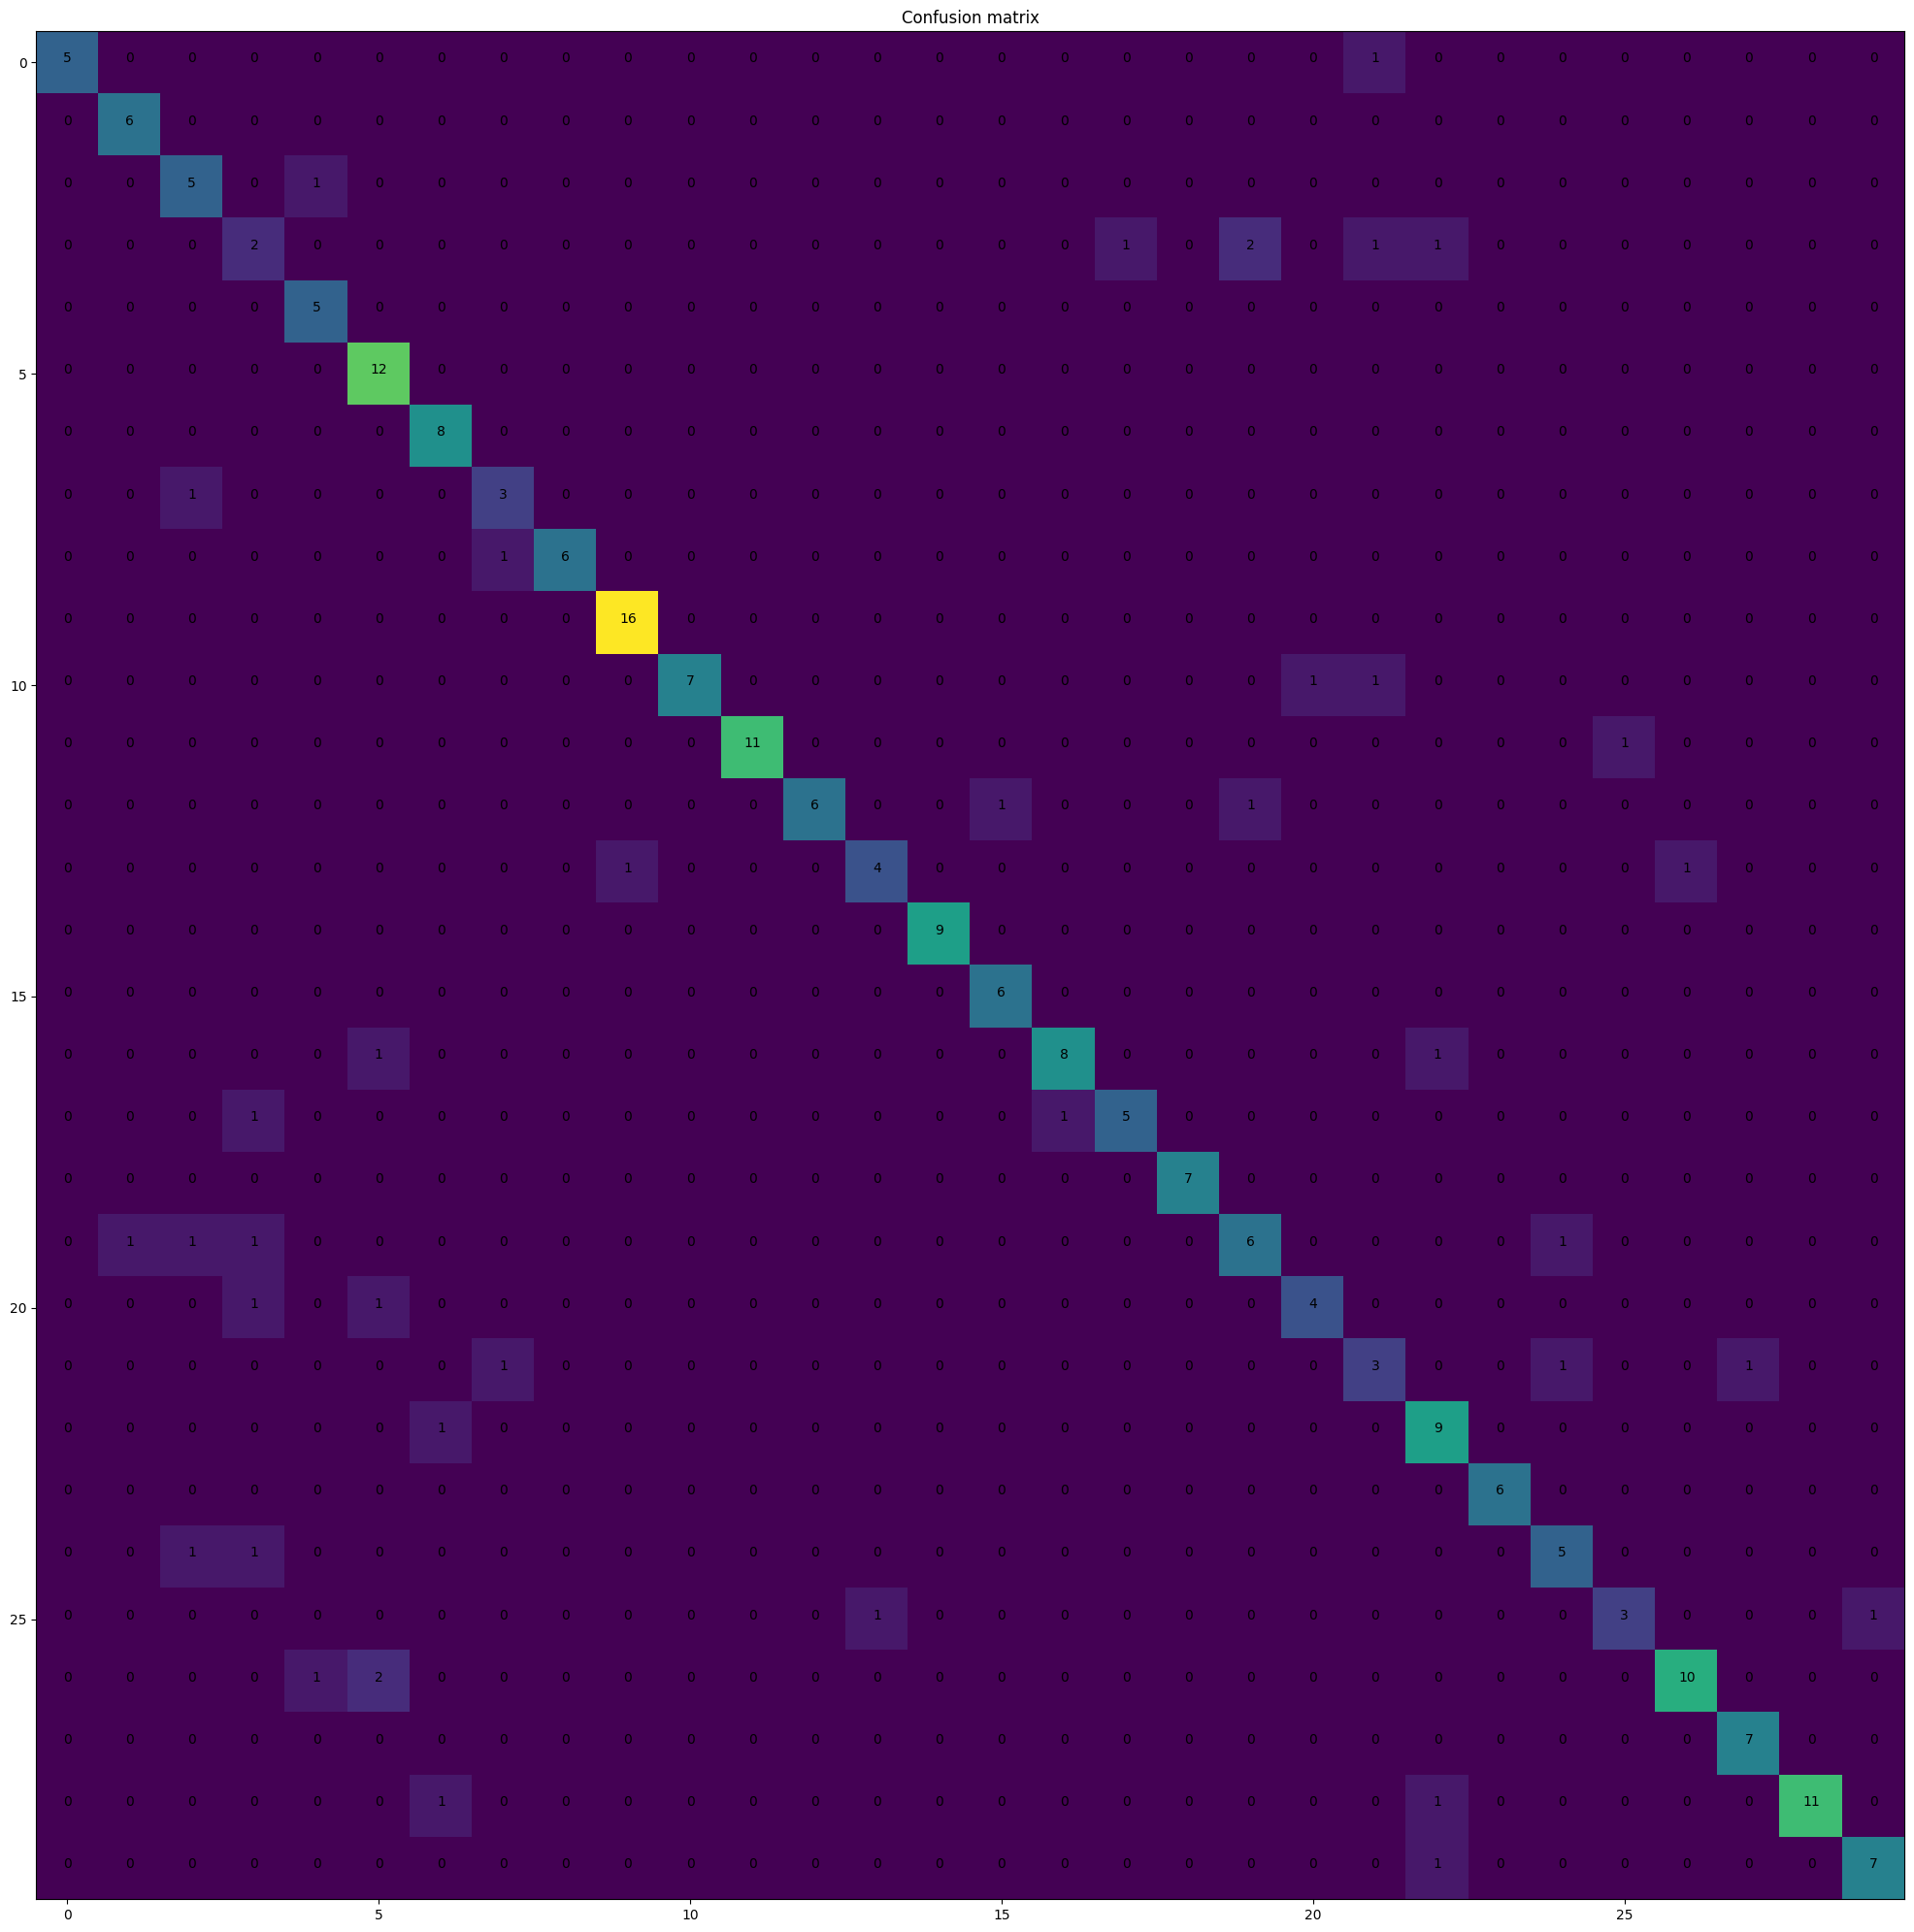

In [48]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

### Model 5

In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

# Input shape for the model
input_shape = (10, 80, 60, 3)

# Now, we build a Conv3D model
model5 = Sequential()
model5.add(Conv3D(32, kernel_size=(3, 3, 3), activation='LeakyReLU', input_shape=input_shape, padding='same'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Conv3D(64, kernel_size=(3, 3, 3), activation='LeakyReLU', padding='same'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(Conv3D(64, kernel_size=(3, 3, 3), activation='LeakyReLU', padding='same'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output before feeding into the fully connected layers
model5.add(Flatten())
#model5.add(Dense(4096, activation="relu"))
model5.add(Dense(30, activation='softmax'))

model5.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 10, 80, 60, 32)    2624      
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 5, 40, 30, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 5, 40, 30, 64)     55360     
                                                                 
 max_pooling3d_33 (MaxPoolin  (None, 2, 20, 15, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_8 (Conv3D)           (None, 2, 20, 15, 64)     110656    
                                                                 
 max_pooling3d_34 (MaxPoolin  (None, 1, 10, 7, 64)   

In [59]:
model5.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3), metrics='accuracy')

es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history5 = model5.fit(x_train, to_categorical(y_train), batch_size=32, epochs=50,
                    validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Epoch 1/50
119/119 [==============================] - 165s 1s/step - loss: 2.1989 - accuracy: 0.3746 - val_loss: 1.4240 - val_accuracy: 0.5950
Epoch 2/50
119/119 [==============================] - 167s 1s/step - loss: 0.9821 - accuracy: 0.7170 - val_loss: 0.7993 - val_accuracy: 0.7562
Epoch 3/50
119/119 [==============================] - 168s 1s/step - loss: 0.5591 - accuracy: 0.8349 - val_loss: 0.6576 - val_accuracy: 0.8223
Epoch 4/50
119/119 [==============================] - 169s 1s/step - loss: 0.3456 - accuracy: 0.8971 - val_loss: 0.5606 - val_accuracy: 0.8430
Epoch 5/50
119/119 [==============================] - 168s 1s/step - loss: 0.1735 - accuracy: 0.9457 - val_loss: 0.5764 - val_accuracy: 0.8554
Epoch 6/50
119/119 [==============================] - 166s 1s/step - loss: 0.1523 - accuracy: 0.9478 - val_loss: 0.6832 - val_accuracy: 0.8182
Epoch 7/50
119/119 [==============================] - 166s 1s/step - loss: 0.1074 - accuracy: 0.9665 - val_loss: 0.5587 - val_accuracy: 0.8719

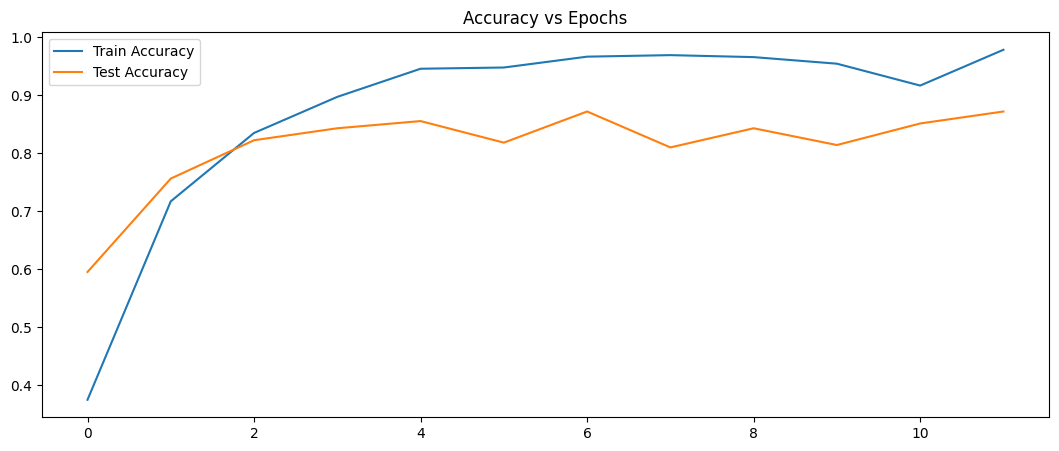

In [60]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history5.history['accuracy'], label='Train Accuracy')
plt.plot(history5.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [61]:
y_pred = model5.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))
#Test Accuracy
accuracy_score(y_test, predicted_classes)

8/8 [==============================] - 1s 167ms/step


0.871900826446281

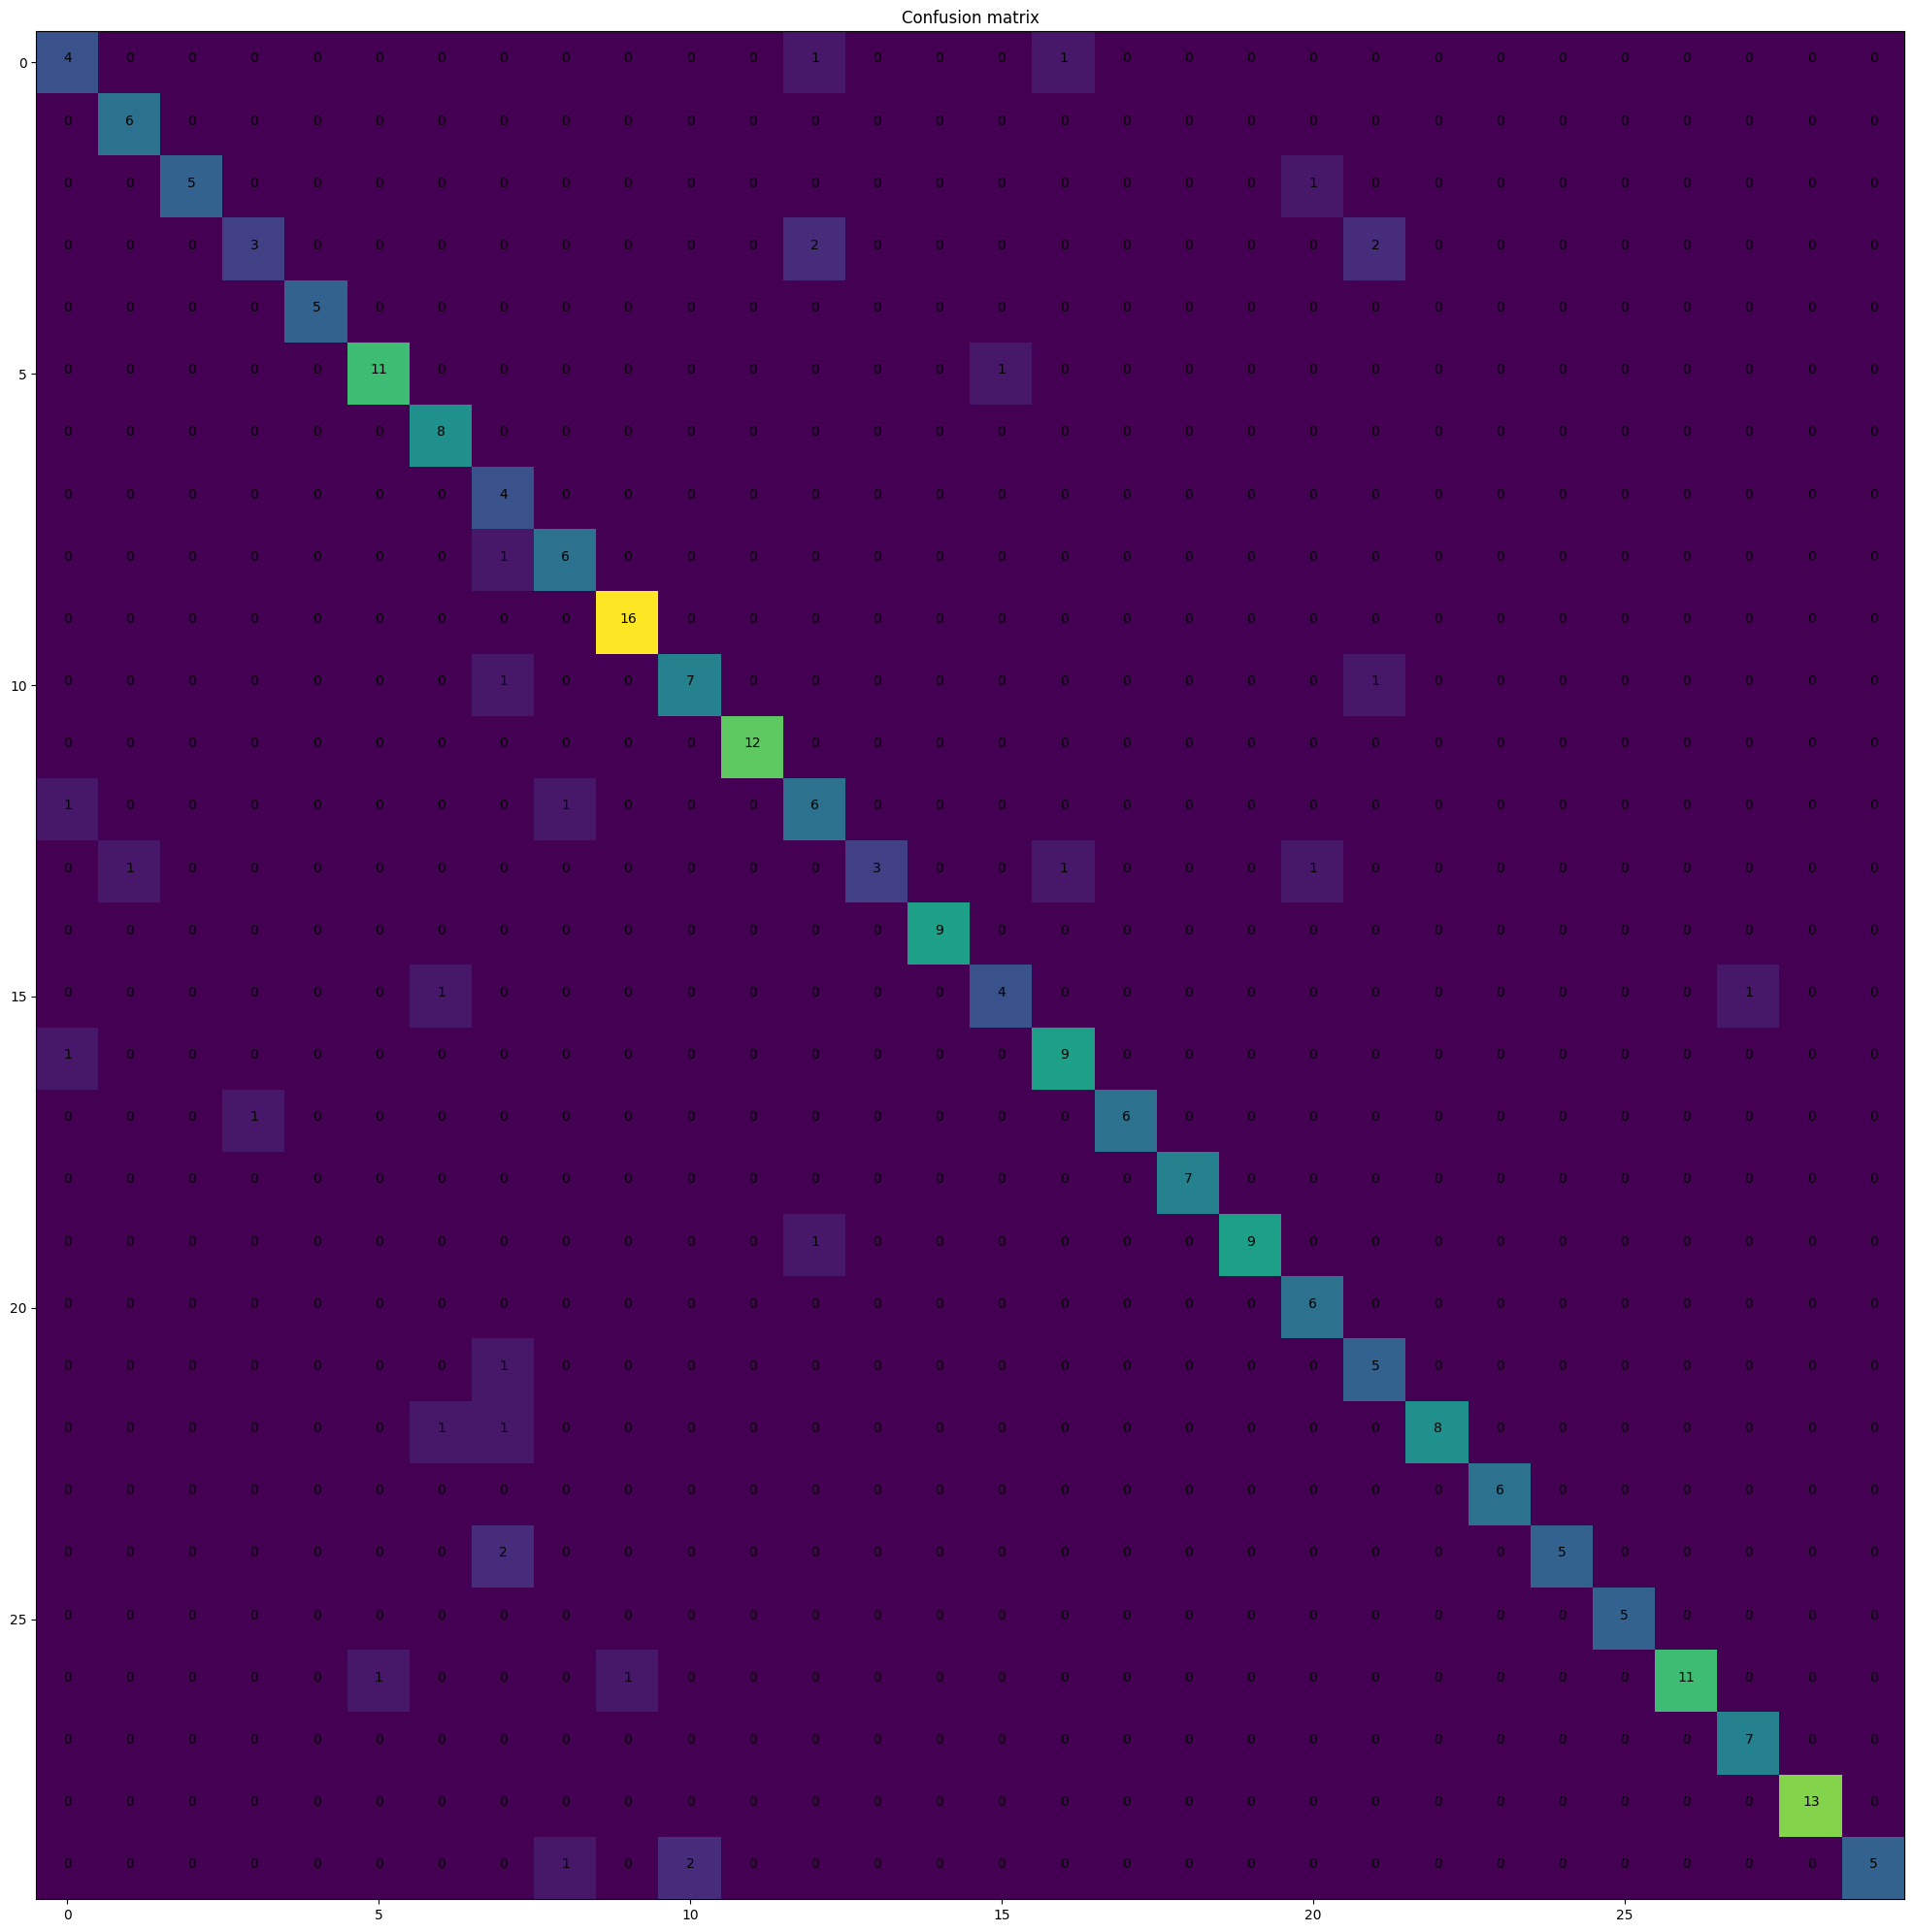

In [62]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

### Save Model

In [40]:
model_save_path = "/Users/LeoSu/Desktop/research/model1"
model.save(model_save_path)

INFO:tensorflow:Assets written to: /Users/LeoSu/Desktop/research/model1/assets


INFO:tensorflow:Assets written to: /Users/LeoSu/Desktop/research/model1/assets


In [65]:
model_save_path = "/Users/LeoSu/Desktop/research/model"
saved_model.save(model, model_save_path)

INFO:tensorflow:Assets written to: /Users/LeoSu/Desktop/research/model/assets


INFO:tensorflow:Assets written to: /Users/LeoSu/Desktop/research/model/assets


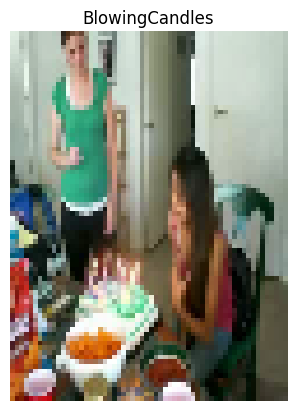

In [17]:
# 这里是使用视频第一帧来预测，然后展示第一帧的画面和结果

import random
import cv2
import tensorflow as tf

# Load class labels
label_data = pd.read_csv("/Users/LeoSu/Desktop/research/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns = ['index', 'class_name']
class_labels = label_data['class_name'].values

# Load the saved model
model_save_path = "/Users/LeoSu/Desktop/research/model"
#loaded_model = tf.keras.models.load_model(model_save_path)
loaded_model = tf.saved_model.load(model_save_path)

# Select a random video from the test set
random_index = random.randint(0, len(x_test) - 1)
random_video = x_test[random_index]

# Duplicate the first frame to create a sequence of frames
sequence_length = 10  # The same as used during training
sequence = [random_video[0]] * sequence_length

# Expand the dimensions to match the input shape of the model
sequence = np.expand_dims(sequence, axis=0)

# Make a prediction using the loaded model
sequence = tf.cast(sequence, tf.float32)  # convert to float32
predict_fn = loaded_model.signatures["serving_default"]
prediction_dict = predict_fn(sequence)
output_layer_name = list(prediction_dict.keys())[0]  # Get the name of the output layer from the dictionary keys
prediction = prediction_dict[output_layer_name]

# Convert the prediction tensor to a numpy array
prediction = prediction.numpy()

predicted_class = np.argmax(prediction)

# Get the class label for the predicted class
predicted_class_label = class_labels[predicted_class]

# Convert the first frame to the correct data type (uint8) for visualization
first_frame_rgb = cv2.cvtColor((random_video[0] * 255).astype('uint8'), cv2.COLOR_BGR2RGB)

# Display the first frame with the predicted class label
plt.imshow(first_frame_rgb)
plt.title(f"{predicted_class_label}")
plt.axis('off')
plt.show()

In [33]:
# 这里对视频的每一帧进行单独的预测（不是完整视频的预测），然后在处理过的视频上展示每一帧

import random
import cv2
import tensorflow as tf

# Load class labels
label_data = pd.read_csv("/Users/LeoSu/Desktop/research/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns = ['index', 'class_name']
class_labels = label_data['class_name'].values

# Load the saved model
model_save_path = "/Users/LeoSu/Desktop/research/model"
loaded_model = tf.saved_model.load(model_save_path)

# Select a random video from the test set
random_index = random.randint(0, len(x_test) - 1)
random_video = x_test[random_index]

# Expand the dimensions to match the input shape of the model
random_video = np.expand_dims(random_video, axis=0)

# Make a prediction using the loaded model
random_video = tf.cast(random_video, tf.float32)  # convert to float32
predict_fn = loaded_model.signatures["serving_default"]
prediction_dict = predict_fn(random_video)
output_layer_name = list(prediction_dict.keys())[0]  # Get the name of the output layer from the dictionary keys
prediction = prediction_dict[output_layer_name]

# Convert the prediction tensor to a numpy array
prediction = prediction.numpy()

# Get the predicted class for the current frame
predicted_class = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class]

# Create a new video writer to save the processed frames
output_video_path = "/path/to/output/video.mp4"
frame_rate = 30  # Frames per second
frame_width, frame_height = random_video.shape[2], random_video.shape[3]
output_video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (frame_width, frame_height))

# Iterate through frames in the video and make predictions
for frame in random_video[0]:
    frame_rgb = cv2.cvtColor((frame.numpy() * 255).astype('uint8'), cv2.COLOR_BGR2RGB)

    # Display the frame with the predicted class label
    cv2.putText(frame_rgb, f"{predicted_class_label}", (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)
    cv2.imshow("Video with Predictions", frame_rgb)

    # Write the frame to the output video
    output_video_writer.write(frame_rgb)

    # Wait for 1 second (1000 milliseconds)
    cv2.waitKey(1000)

    # Select the next predicted class for the next frame (random for demonstration purposes)
    predicted_class = random.randint(0, len(class_labels) - 1)
    predicted_class_label = class_labels[predicted_class]

# Release the video writer and close the display window
output_video_writer.release()
cv2.destroyAllWindows()


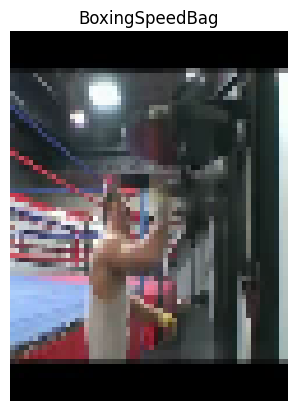

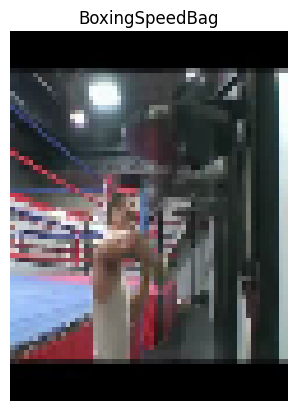

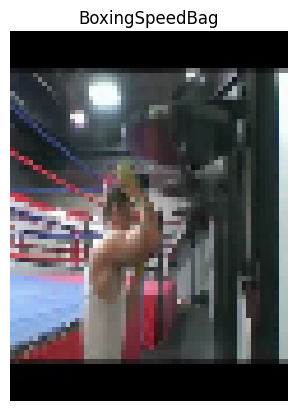

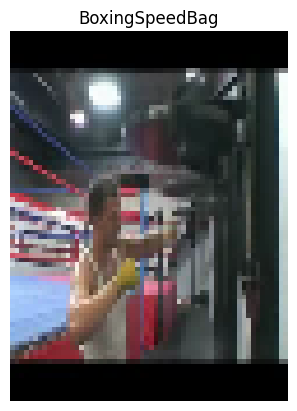

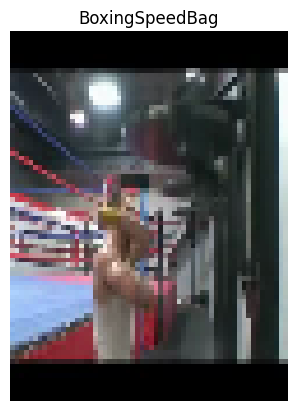

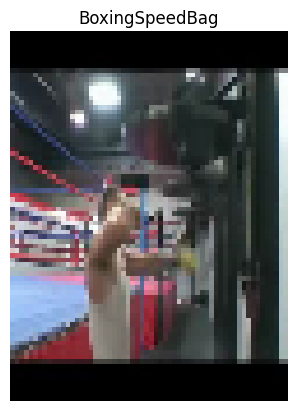

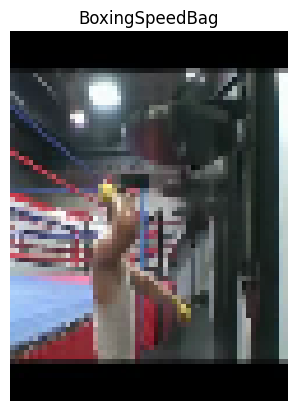

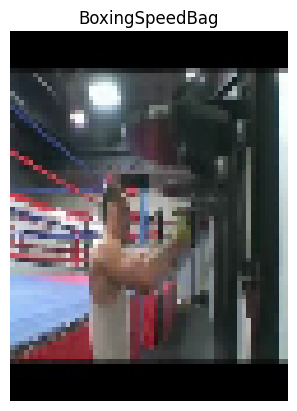

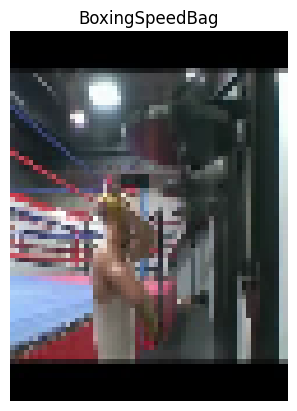

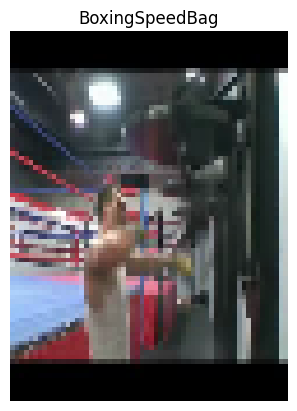

In [8]:
# 使用完整的视频进行预测，然后展示每一帧

import random
import cv2
import tensorflow as tf

# 定义一个函数来播放视频并展示预测结果
def display_video_with_prediction(video_frames, class_label):
    for frame in video_frames:
        frame_rgb = cv2.cvtColor((frame * 255).astype('uint8'), cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.title(f"{class_label}")
        plt.axis('off')
        plt.show()
        plt.pause(0.1) # 0.1秒暂停，您可以调整这个值来改变播放速度
    plt.close()

# ...

# 在随机选择的视频上运行预测
random_index = random.randint(0, len(x_test) - 1)
random_video = x_test[random_index]

# 复制整个视频序列以匹配模型的输入形状
sequence = np.expand_dims(random_video, axis=0)

# 使用加载的模型进行预测
sequence = tf.cast(sequence, tf.float32)
predict_fn = loaded_model.signatures["serving_default"]
prediction_dict = predict_fn(sequence)
output_layer_name = list(prediction_dict.keys())[0]
prediction = prediction_dict[output_layer_name]

# 将预测张量转换为numpy数组并获取预测的类
prediction = prediction.numpy()
predicted_class = np.argmax(prediction)

# 获取预测类的标签
predicted_class_label = class_labels[predicted_class]

# 使用定义的函数播放视频并展示预测结果
display_video_with_prediction(random_video, predicted_class_label)


In [30]:
# 使用完整的视频进行预测，并以视频的形式展示

import random
import cv2
import tensorflow as tf

def display_video_with_prediction(video_frames, class_label):
    while True:  # 无限循环，使视频不断重复播放
        for frame in video_frames:
            frame_rgb = cv2.cvtColor((frame * 255).astype('uint8'), cv2.COLOR_BGR2RGB)
            cv2.putText(frame_rgb, class_label, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1, cv2.LINE_AA)
            cv2.imshow('Video with Prediction', frame_rgb)
            if cv2.waitKey(100) & 0xFF == ord('q'):  # 调整等待时间以控制播放速度
                cv2.destroyAllWindows()
                return  # 如果按下“q”键，则退出循环并关闭窗口

# ...

# 在随机选择的视频上运行预测
random_index = random.randint(0, len(x_test) - 1)
random_video = x_test[random_index]

# 复制整个视频序列以匹配模型的输入形状
sequence = np.expand_dims(random_video, axis=0)

# 使用加载的模型进行预测
sequence = tf.cast(sequence, tf.float32)
predict_fn = loaded_model.signatures["serving_default"]
prediction_dict = predict_fn(sequence)
output_layer_name = list(prediction_dict.keys())[0]
prediction = prediction_dict[output_layer_name]

# 将预测张量转换为numpy数组并获取预测的类
prediction = prediction.numpy()
predicted_class = np.argmax(prediction)

# 获取预测类的标签
predicted_class_label = class_labels[predicted_class]

# 使用定义的函数播放视频并展示预测结果
display_video_with_prediction(random_video, predicted_class_label)


In [31]:
# 这里用每一帧来预测（不是完整视频的预测），然后在原视频上显示当前帧的预测结果

def display_video_with_prediction(video_path, model, class_labels):
    video_reader = cv2.VideoCapture(video_path)
    sequence_length = 10  # 与训练时相同的序列长度
    frames_list = []

    while True:
        ret, frame = video_reader.read()
        if not ret:
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)  # 重新开始播放
            continue

        frame_resized = cv2.resize(frame, (80, 60)) / 255  # 调整大小并归一化，与训练时的预处理相匹配
        frames_list.append(frame_resized)

        if len(frames_list) == sequence_length:
            sequence = np.array([frames_list])  # 创建一个与模型输入匹配的序列
            sequence = tf.cast(sequence, tf.float32)
            predict_fn = model.signatures["serving_default"]
            prediction_dict = predict_fn(sequence)
            output_layer_name = list(prediction_dict.keys())[0]
            prediction = prediction_dict[output_layer_name]
            prediction = prediction.numpy()
            predicted_class = np.argmax(prediction)
            predicted_class_label = class_labels[predicted_class]
            frames_list.pop(0)  # 删除最旧的帧，以便下次迭代
            cv2.putText(frame, predicted_class_label, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
        cv2.imshow('Video with Prediction', frame)
        
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    video_reader.release()
    cv2.destroyAllWindows()

# 选择一个随机视频文件进行预测
random_label_folder = random.choice(path)
random_video_file = random.choice(os.listdir(random_label_folder))
random_video_path = os.path.join(random_label_folder, random_video_file)

# 使用定义的函数播放视频并展示预测结果
display_video_with_prediction(random_video_path, loaded_model, class_labels)

In [41]:
import tensorflow as tf
print(tf.__version__)


2.12.0
